In [449]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

In [450]:
df_repeater=pd.read_csv("../Processed Data/prd_order_value.csv")

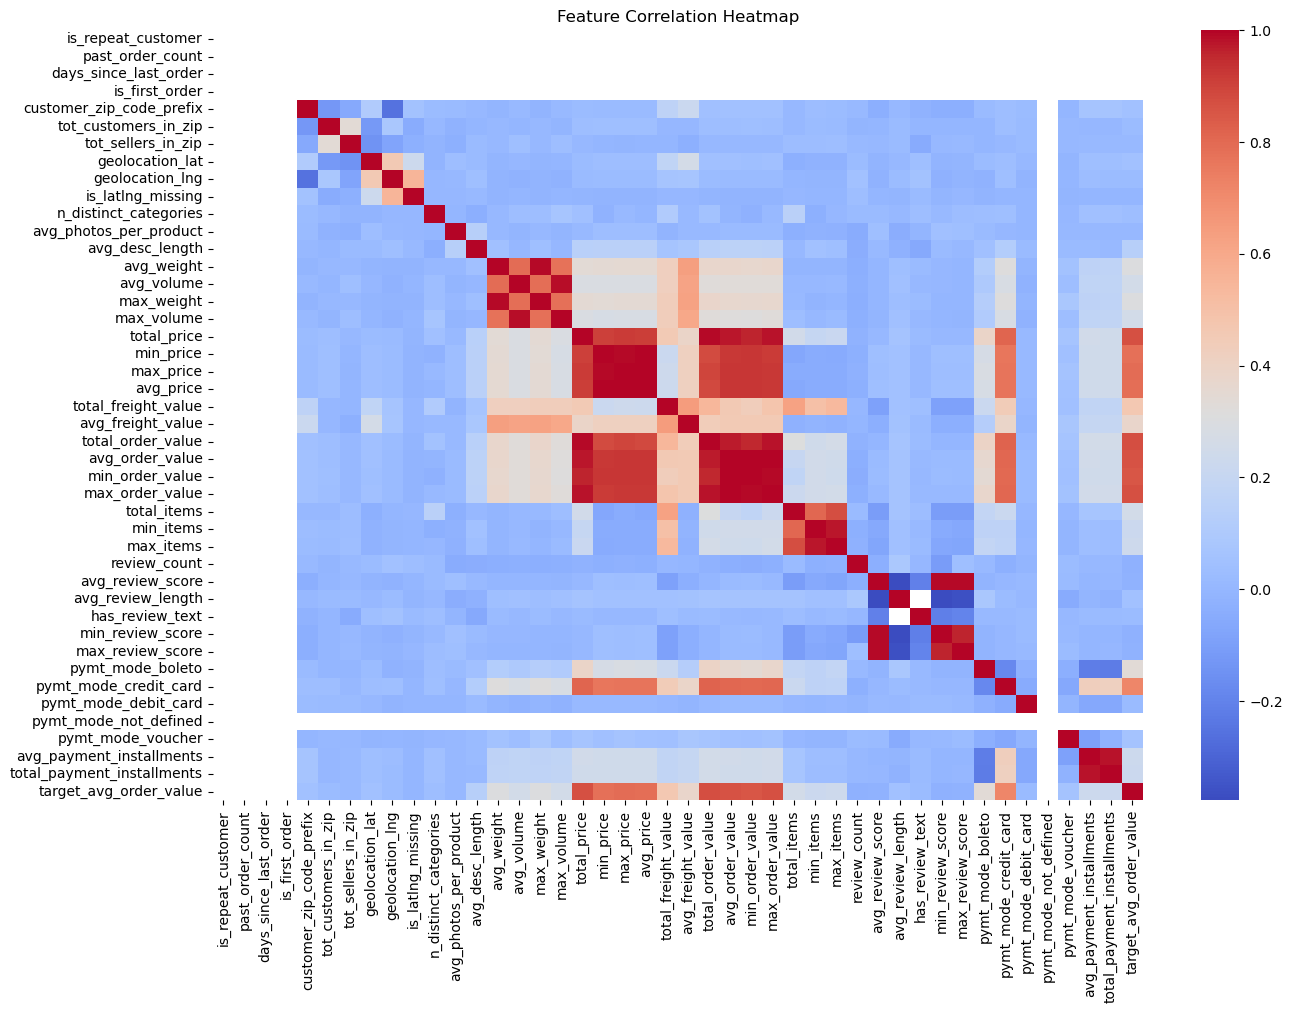

Potential Redundant Features (Corr > 0.85):
min_price               avg_price                 0.998682
avg_price               min_price                 0.998682
max_price               avg_price                 0.998610
avg_price               max_price                 0.998610
avg_order_value         max_order_value           0.997518
                                                    ...   
total_price             target_avg_order_value    0.868172
target_avg_order_value  max_order_value           0.866162
max_order_value         target_avg_order_value    0.866162
target_avg_order_value  avg_order_value           0.860121
avg_order_value         target_avg_order_value    0.860121
Length: 80, dtype: float64


In [451]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df_repeater.select_dtypes(include=[np.number])


corr_matrix = numeric_df.corr()


plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

high_corr = corr_matrix.unstack().sort_values(ascending=False)
high_corr = high_corr[(high_corr > 0.85) & (high_corr < 1.0)]
print("Potential Redundant Features (Corr > 0.85):")
print(high_corr)

In [452]:
redundant_cols = [
    'customer_id','order_id','order_purchase_timestamp','snapshot_date','is_repeat_customer','past_order_count'
    ,'days_since_last_order','is_first_order','customer_unique_id','customer_zip_code_prefix','customer_city','customer_state',
    'geolocation_lat','geolocation_lng','is_latlng_missing','total_freight_value','avg_freight_value','avg_order_value','total_order_value'
    ,'min_price', 'max_price','min_items','max_items','review_count','min_review_score','max_review_score','min_order_value', 'max_order_value', 
    'total_price','total_items', 'min_items' ,'max_items' ,'max_weight' , 'max_volume','total_price','avg_price']

df_repeater = df_repeater.drop(columns=redundant_cols)

In [453]:
from scipy.stats import skew

numeric_cols = df_repeater.select_dtypes(include=[np.number]).columns
skewness_values = df_repeater[numeric_cols].skew().sort_values(ascending=False)

high_skew = skewness_values[abs(skewness_values) > 0.75]
print("Highly Skewed Features:")
print(high_skew)

Highly Skewed Features:
pymt_mode_debit_card          17.781646
pymt_mode_voucher             17.671200
pymt_mode_credit_card         10.656370
pymt_mode_boleto               8.307521
target_avg_order_value         8.084806
avg_weight                     3.705003
avg_volume                     3.620561
tot_sellers_in_zip             3.580880
tot_customers_in_zip           2.593913
avg_desc_length                2.199787
avg_photos_per_product         2.049783
avg_payment_installments       1.334086
total_payment_installments     1.316568
avg_review_length              1.141233
n_distinct_categories          0.881574
avg_review_score              -1.482828
dtype: float64


In [454]:
skewed_features = high_skew.index.tolist()
df_repeater['target_avg_order_value_log'] = np.log1p(df_repeater['target_avg_order_value'])
for col in skewed_features:
    if col in df_repeater.columns:
        df_repeater[col] = np.log1p(df_repeater[col])

In [455]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


leaky_cols = ['target_avg_order_value', 'target_avg_order_value_log']
X = df_repeater.drop(columns=leaky_cols)
y = df_repeater['target_avg_order_value_log']


X_encoded = pd.get_dummies(X, columns=['main_category'], drop_first=True)
X_final = X_encoded.fillna(X_encoded.median()) 


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

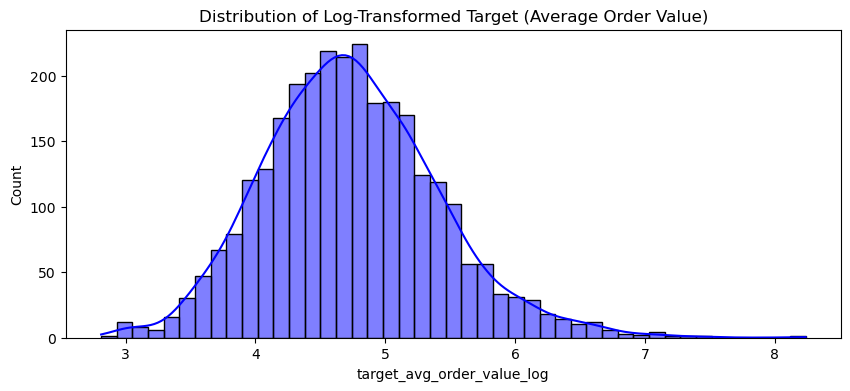

In [456]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.histplot(y, kde=True, color='blue')
plt.title("Distribution of Log-Transformed Target (Average Order Value)")
plt.show()

In [457]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ridge = Ridge()
parameters = {'alpha': [0.01, 0.1, 1, 10, 100, 500]} 


grid_ridge = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_
print(f"Best Alpha: {grid_ridge.best_params_['alpha']}")

Best Alpha: 1


In [458]:

y_pred_log = best_ridge.predict(X_test)


y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)


print("--- Linear Regression (Ridge) Performance ---")
print(f"R2 Score (Log Scale): {r2_score(y_test, y_pred_log):.4f}")
print(f"MAE (Actual Dollars): ${mean_absolute_error(y_test_actual, y_pred_actual):.2f}")
print(f"RMSE (Actual Dollars): ${np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)):.2f}")

--- Linear Regression (Ridge) Performance ---
R2 Score (Log Scale): 0.5822
MAE (Actual Dollars): $48.63
RMSE (Actual Dollars): $98.37


/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_29218/326048275.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


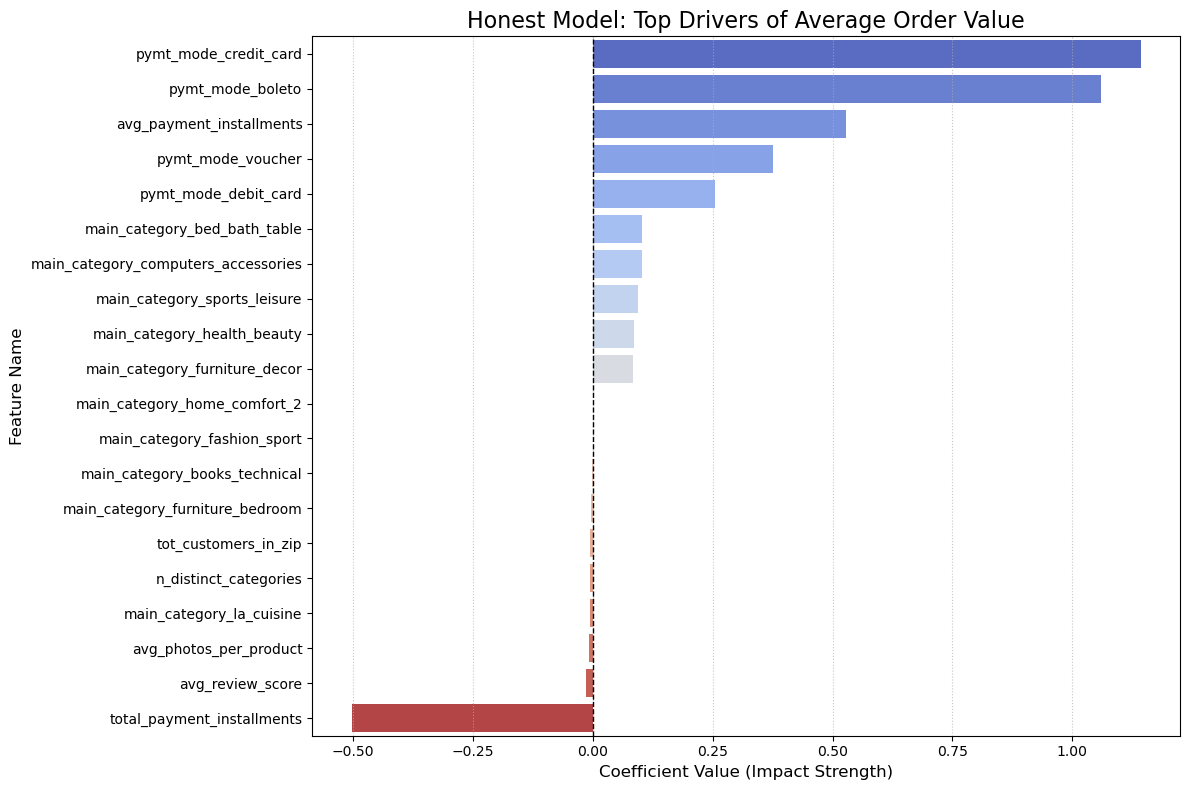

In [459]:
best_ridge = grid_ridge.best_estimator_

# 6. FEATURE IMPORTANCE (This will now have matching lengths!)
importance_df = pd.DataFrame({
    'Feature': X_train_raw.columns,
    'Coefficient': best_ridge.coef_
}).sort_values(by='Coefficient', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select the Top 10 (High Spend) and Bottom 10 (Low Spend) features
top_bottom_features = pd.concat([importance_df.head(10), importance_df.tail(10)])

# 2. Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_bottom_features, 
    x='Coefficient', 
    y='Feature', 
    palette='coolwarm'
)

# 3. Add styling for a professional look
plt.title('Honest Model: Top Drivers of Average Order Value', fontsize=16)
plt.xlabel('Coefficient Value (Impact Strength)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1) # Zero line to separate +/-
plt.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

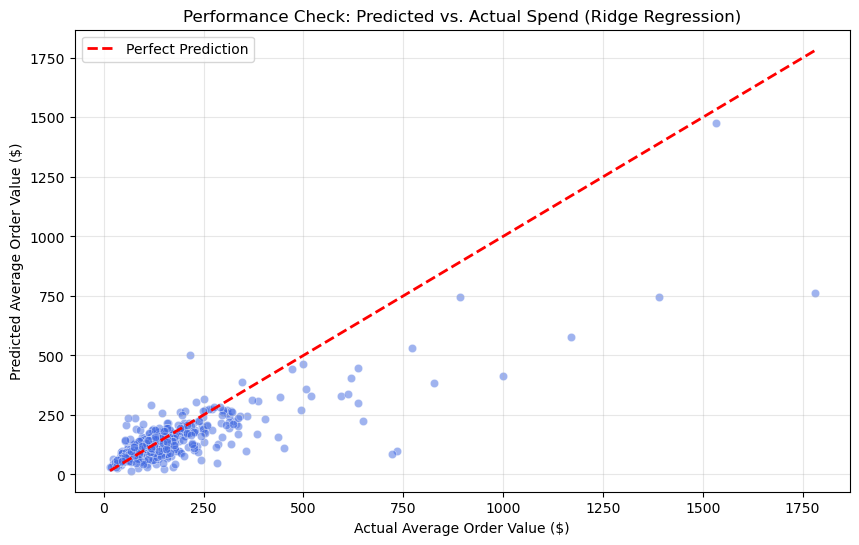

In [460]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Ensure we are comparing actual dollars, not log values
# Assuming y_test and y_pred_log are your current variables
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 2. Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5, color='royalblue')

# 3. Add the 45-degree "Perfect Prediction" line
max_val = max(y_test_actual.max(), y_pred_actual.max())
min_val = min(y_test_actual.min(), y_pred_actual.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')

# 4. Formatting
plt.xlabel('Actual Average Order Value ($)')
plt.ylabel('Predicted Average Order Value ($)')
plt.title('Performance Check: Predicted vs. Actual Spend (Ridge Regression)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [461]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Define the model
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# 2. Hyperparameter Grid
# n_estimators: Number of trees
# max_depth: Complexity of each tree
# learning_rate: How much we trust each tree (prevents overfitting)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 3. Run the Search
xgb_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid, 
    n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42
)

xgb_search.fit(X_train, y_train)

# 4. Get the best model
best_xgb = xgb_search.best_estimator_
print(f"Best XGB Parameters: {xgb_search.best_params_}")

Best XGB Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [462]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predictions
y_pred_xgb_log = best_xgb.predict(X_test)

# Inverse log to actual dollars
y_test_dollars = np.expm1(y_test)
y_pred_xgb_dollars = np.expm1(y_pred_xgb_log)

# Metrics
print("--- XGBoost Performance ---")
print(f"R2 Score (Log Scale): {r2_score(y_test, y_pred_xgb_log):.4f}")
print(f"MAE (Actual Dollars): ${mean_absolute_error(y_test_dollars, y_pred_xgb_dollars):.2f}")
print(f"RMSE (Actual Dollars): ${np.sqrt(mean_squared_error(y_test_dollars, y_pred_xgb_dollars)):.2f}")

--- XGBoost Performance ---
R2 Score (Log Scale): 0.6884
MAE (Actual Dollars): $43.49
RMSE (Actual Dollars): $97.67


In [463]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit it using the same scaled data from our Ridge run
xgb_model.fit(X_train_scaled, y_train)

# Assign it to a variable we can use for predictions
best_xgb = xgb_model

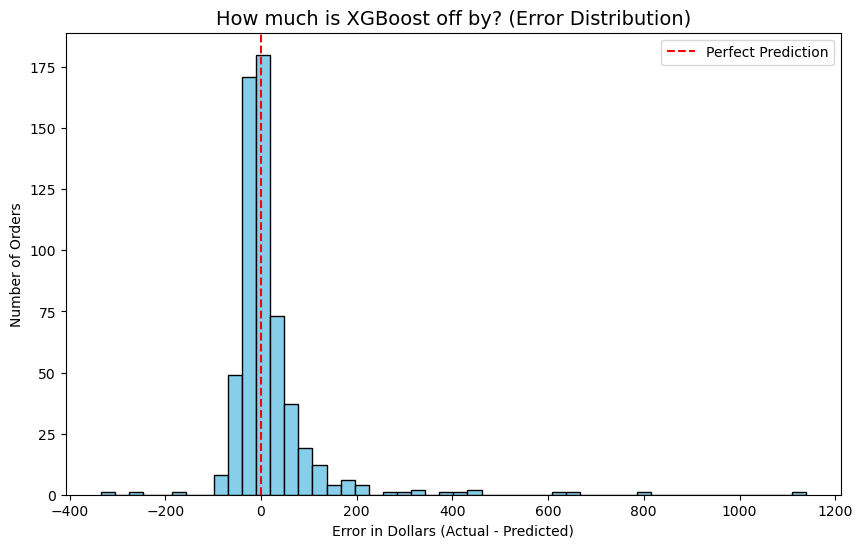

In [464]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Predict using the scaled test data
y_pred_log = best_xgb.predict(X_test_scaled)

# 2. Convert back to actual Dollars
y_pred_dollars = np.expm1(y_pred_log)
y_test_dollars = np.expm1(y_test)

# 3. Calculate the Error (Residuals)
residuals = y_test_dollars - y_pred_dollars

# 4. Plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title('How much is XGBoost off by? (Error Distribution)', fontsize=14)
plt.xlabel('Error in Dollars (Actual - Predicted)')
plt.ylabel('Number of Orders')
plt.axvline(x=0, color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

/var/folders/jr/cx9v05mj76767q_pxc111nvr0000gn/T/ipykernel_29218/3916120774.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df_xgb.head(15), x='Importance', y='Feature', palette='viridis')


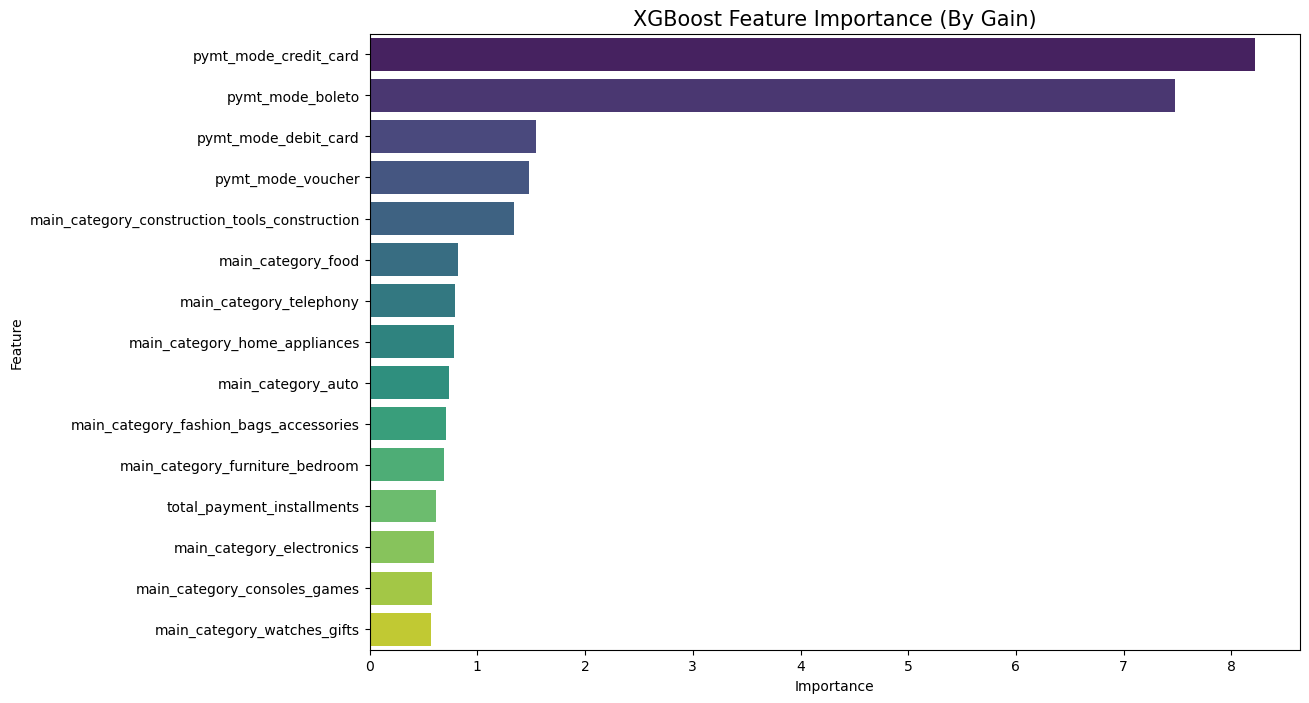

In [465]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get importance (XGBoost uses 'weight' by default, but 'gain' is usually better for spend)
importance_types = ['gain', 'weight']
# 'gain' tells us which feature contributed most to the model's accuracy
feat_importance = best_xgb.get_booster().get_score(importance_type='gain')

# 2. Map back to column names
# Since the model was trained on X_train_raw.columns
importance_df_xgb = pd.DataFrame({
    'Feature': X_train_raw.columns,
    'Importance': [feat_importance.get(f'f{i}', 0) for i in range(len(X_train_raw.columns))]
}).sort_values(by='Importance', ascending=False)

# 3. Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df_xgb.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance (By Gain)', fontsize=15)
plt.show()

In [466]:
joblib.dump(best_ridge, 'linear_spend_model_ridge.pkl')
joblib.dump(best_xgb, 'final_spend_model_xgb.pkl')
joblib.dump(scaler, 'final_scaler.pkl')


['final_scaler.pkl']